In [22]:
import configparser
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from pathlib import Path
from model import DnCNN
import data_generator as dg
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from timeit import default_timer as timer
import cv2
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import glob
from BM3D.noise_model import poissonpoissonnoise as nm
import datetime
#from vgg import Vgg16
from torchvision import transforms


STYLE_WEIGHT = 1e5
CONTENT_WEIGHT = 1e0
manualSeed = 999
# # manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)


def save_model(net: nn.Module, model_save_dir, step, dose_total):
    """
    Save the trained model.

    Args:
        net: trained model.
        model_save_dir: saved model directory.
        step: checkpoint.
    """
    model_save_dir = Path(model_save_dir) / "dose{}".format(str(int(dose_total)))
    if not Path(model_save_dir).exists():
        Path.mkdir(model_save_dir)
    model_path = Path(model_save_dir) / "{}.pth".format(step + 1)

    torch.save(net.state_dict(), model_path)

    print("Saved model checkpoints {} into {}".format(step + 1, model_save_dir))


def restore_model(resume_iters, model_save_dir, net: nn.Module, train=False):
    """
    Restore the trained model.

    Args:
        resume_iters: the iteration to be loaded.
        model_save_dir: the directory for saving the model.
        net: the model instance to be loaded.
        train: if True, then the model is set to training;
               else set it to test.

    Returns:
        net: loaded model instance.

    """
    print("Loading the trained model from step {}".format(resume_iters))
    #model_path = Path(model_save_dir) / "{}.pth".format(resume_iters)
    model_path = '/home/mertcan/Desktop/CS-EC523-A1-DeepLearning/Final_project/KAIR/29.pth'
    # Restore the model.
    net.load_state_dict(torch.load(model_path))

    if train:
        net.train()
    else:
        net.eval()

    return net


class LossFunc(nn.Module):
    def __init__(self, reduction="sum"):
        super(LossFunc, self).__init__()
        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=reduction)
        # TODO: to add TV loss.
        # self.tv_loss =
        # TODO: to add likelihood
        # self.log_loss =

    def forward(self, logits, target):
        # Return the average MSE loss.
        mse_loss = self.mse_loss(logits, target).div_(2)
        loss = mse_loss
        return loss


def test_model(config, model_path):
    depth = int(config["DnCNN"]["depth"])
    n_channels = int(config["DnCNN"]["n_channels"])
    img_channel = int(config["DnCNN"]["img_channel"])
    kernel_size = int(config["DnCNN"]["kernel_size"])
    use_bnorm = config.getboolean("DnCNN", "use_bnorm")
    epochs = int(config["DnCNN"]["epoch"])
    batch_size = int(config["DnCNN"]["batch_size"])
    train_data_dir = config["DnCNN"]["train_data_dir"]
    test_data_dir = config["DnCNN"]["test_data_dir"]
    eta_min = float(config["DnCNN"]["eta_min"])
    eta_max = float(config["DnCNN"]["eta_max"])
    dose = float(config["DnCNN"]["dose"])
    model_save_dir = config["DnCNN"]["model_save_dir"]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initiate a DnCNN instance.
    # Load the model to device and set the model to training.
    model = DnCNN(depth=depth, n_channels=n_channels,
                  img_channel=img_channel,
                  use_bnorm=use_bnorm,
                  kernel_size=kernel_size)
                  
    ######## YOU NEED TO CHANGE THIS TO THE LOCATION OF THE WEIGHTS
    model.load_state_dict(torch.load(model_path))
                      
    model = model.to(device)
    model.eval()
    
    # Get a validation test set and corrupt with noise for validation performance.
    # For every epoch, use this pre-determined noisy images.
    test_file_list = glob.glob(test_data_dir + "/*.png")
    xs_test = []
    # Can't directly convert the xs_test from list to ndarray because some images are 512*512
    # while the rest are 256*256.
    for i in range(len(test_file_list)):
        img = cv2.imread(test_file_list[i], 0)
        img = np.array(img, dtype="float32") / 255.0
        img = np.expand_dims(img, axis=0)
        img_noisy, _ = nm(img, eta_min, eta_max, dose, t=100)
        xs_test.append((img_noisy, img))

    val_psnr = []
    val_ssim = []
    psnr_store=[]
    ssim_store = []
    with torch.no_grad():
        for idx, test_data in enumerate(xs_test):
            inputs, labels = test_data
            inputs = np.expand_dims(inputs, axis=0)
            inputs = torch.from_numpy(inputs).to(device)
            labels = labels.squeeze()

            outputs = model(inputs)
            outputs = outputs.squeeze().cpu().detach().numpy()

            val_psnr.append(peak_signal_noise_ratio(labels, outputs))
            val_ssim.append(structural_similarity(outputs, labels))

    psnr_store.append(sum(val_psnr) / len(val_psnr))
    ssim_store.append(sum(val_ssim) / len(val_ssim))
    print('\nPSNR : ', psnr_store)
    print('\nSSIM : ', ssim_store)
    
    


if __name__=="__main__":
    config = configparser.ConfigParser()

    ######## YOU NEED TO CHANGE THIS TO THE LOCATION OF CONFIGURATION FILE
    config.read(r"C:\Users\unayd\Desktop\EC523_Final_Project\DnCNN\cfg.ini")
    model_path =  r'C:\Users\unayd\Desktop\Model_weights\Reg5e-7.pth'
    test_model(config, model_path)



PSNR :  [17.341283520441333]

SSIM :  [0.6971275348953985]


PSNR : 20.018645480351793
SSIM : 0.7606186327854091


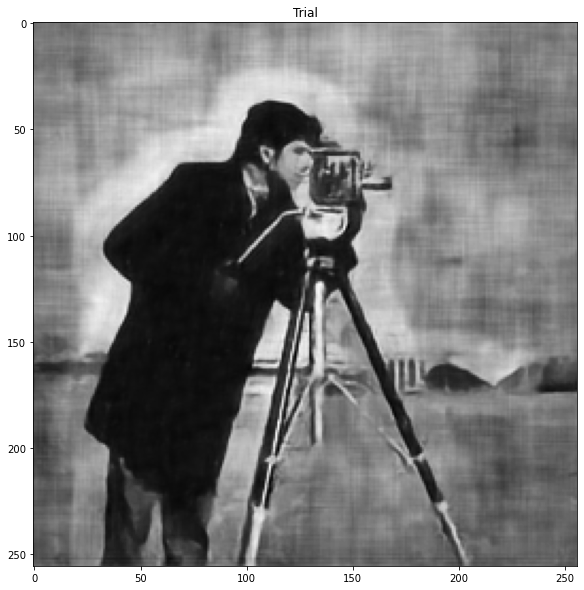

In [24]:
depth = int(config["DnCNN"]["depth"])
n_channels = int(config["DnCNN"]["n_channels"])
img_channel = int(config["DnCNN"]["img_channel"])
kernel_size = int(config["DnCNN"]["kernel_size"])
use_bnorm = config.getboolean("DnCNN", "use_bnorm")
epochs = int(config["DnCNN"]["epoch"])
batch_size = int(config["DnCNN"]["batch_size"])
train_data_dir = config["DnCNN"]["train_data_dir"]
test_data_dir = config["DnCNN"]["test_data_dir"]
eta_min = float(config["DnCNN"]["eta_min"])
eta_max = float(config["DnCNN"]["eta_max"])
dose = float(config["DnCNN"]["dose"])
model_save_dir = config["DnCNN"]["model_save_dir"]

device = torch.device("cpu")

    # Initiate a DnCNN instance.
    # Load the model to device and set the model to training.
model = DnCNN(depth=depth, n_channels=n_channels,
                  img_channel=img_channel,
                  use_bnorm=use_bnorm,
                  kernel_size=kernel_size)
                  
    ######## YOU NEED TO CHANGE THIS TO THE LOCATION OF THE WEIGHTS
model.load_state_dict(torch.load(model_path))
                      
model = model.to(device)
model.eval()



image_dir = r'C:\Users\unayd\Desktop\EC523_Final_Project\DnCNN\data\Test\Set12\01.png'
img = cv2.imread(image_dir, 0)
img = np.array(img, dtype="float32") / 255.0
img = np.expand_dims(img, axis=0)
img_noisy, _ = nm(img, eta_min, eta_max, dose, t=100)

inputs = np.expand_dims(img_noisy, axis=0)
inputs = torch.from_numpy(inputs).to(device)

outputs = model(inputs)
outputs = outputs.squeeze().cpu().detach().numpy()


print('PSNR :', peak_signal_noise_ratio(img.squeeze(), outputs))
print('SSIM :', structural_similarity(outputs, img.squeeze()))

plt.figure(figsize=(10,10))
plt.title('Trial')
plt.imshow( outputs, cmap='gray')
plt.show()


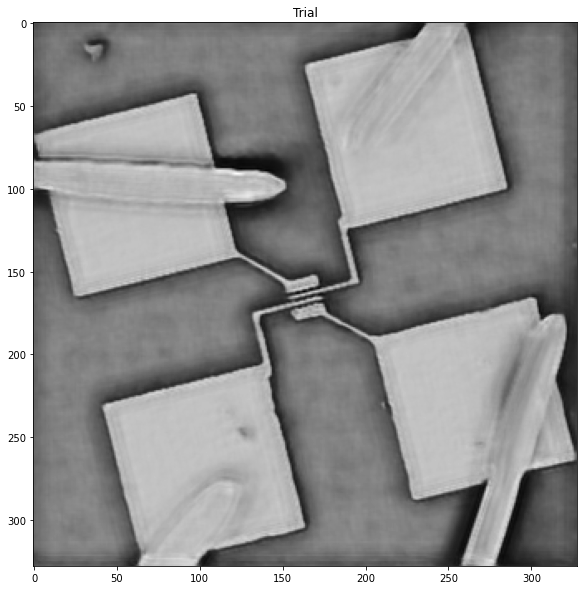

In [19]:
image_dir = r'C:\Users\unayd\Desktop\EC523_Final_Project\DnCNN\mic.jpg'
img = cv2.imread(image_dir, 0)
img = np.array(img, dtype="float32") / 255.0

img = np.expand_dims(img, axis=0)

inputs = np.expand_dims(img, axis=0)
inputs = torch.from_numpy(inputs).to(device)

outputs = model(inputs)
outputs = outputs.squeeze().cpu().detach().numpy()
outputs = (outputs-np.min(outputs))
outputs = outputs/np.max(outputs)

plt.figure(figsize=(10,10))
plt.title('Trial')
plt.imshow( outputs, cmap='gray')
plt.show()